In [484]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchaudio
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
import IPython.display as ipd

from tqdm import tqdm
import torchaudio.transforms as T
from torch.utils.data import TensorDataset, DataLoader
import random
from torch.nn.utils import clip_grad_norm_

In [103]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [387]:
dataset_speech = torchaudio.datasets.SPEECHCOMMANDS('./', download=True)

In [526]:
def data_extractor(dataset, num_samples=5000, validation_split=0.2):

    trigger_samples = []
    non_trigger_samples = []
    
    # Extract samples
    for i in range(num_samples):
        waveform, sample_rate, label, *rest = dataset[i]
        if label == 'backward':
            trigger_samples.append((waveform, sample_rate, label))
        else:
            non_trigger_samples.append((waveform, sample_rate, label))
    
    # Split data into training and validation sets
    num_val_trigger = int(len(trigger_samples) * validation_split)
    num_val_non_trigger = int(len(non_trigger_samples) * validation_split)
    
    train_trigger_samples = trigger_samples[num_val_trigger:]
    val_trigger_samples = trigger_samples[:num_val_trigger]
    
    train_non_trigger_samples = non_trigger_samples[num_val_non_trigger:]
    val_non_trigger_samples = non_trigger_samples[:num_val_non_trigger]
    
    return (train_trigger_samples, train_non_trigger_samples), (val_trigger_samples, val_non_trigger_samples)

In [527]:
(train_trigger_samples, train_non_trigger_samples), (val_trigger_samples, val_non_trigger_samples) = data_extractor(dataset_speech)

In [528]:
print(f"Number of train trigger samples: {len(train_trigger_samples)}")
print(f"Number of train non-trigger samples: {len(train_non_trigger_samples)}")
print(f'Number of val trigger samples: {len(val_trigger_samples)}')
print(f'Number of val non-trigger samples: {len(val_non_trigger_samples)}')

Number of train trigger samples: 1332
Number of train non-trigger samples: 2669
Number of val trigger samples: 332
Number of val non-trigger samples: 667


In [529]:
lab = train_non_trigger_samples[410]
lab

(tensor([[0.0050, 0.0071, 0.0060,  ..., 0.0031, 0.0018, 0.0033]]),
 16000,
 'bed')

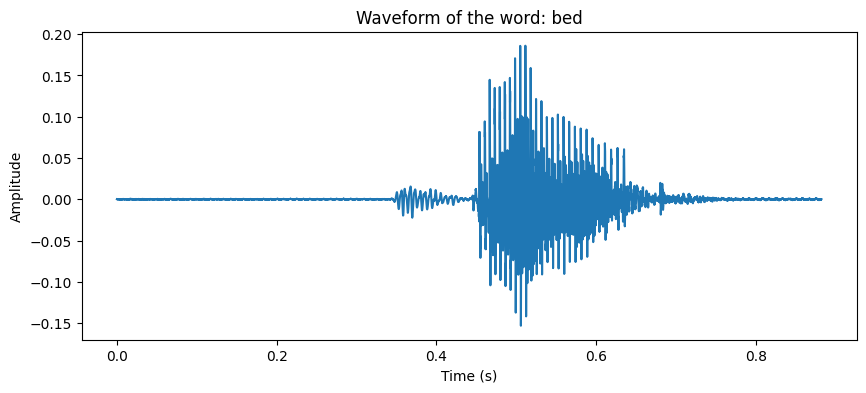

In [531]:
waveform, sample, label = train_non_trigger_samples[20]
waveform_np = waveform.numpy().squeeze() # turn it into 1D instead of 2D to plot

plt.figure(figsize=(10, 4))
plt.plot(np.linspace(0, len(waveform_np)/16000, len(waveform_np)), waveform_np)
plt.title(f"Waveform of the word: {label}")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.show()

In [532]:
ipd.Audio(waveform, rate=16000)

In [533]:
def generate_and_label_spectrogram(waveform, label, target_length=101, n_fft=400, win_len=400, hop_len=160, n_mels=128, sample_rate=16000):
    # Create Mel Spectrogram
    mel_spectrogram = T.MelSpectrogram(
        sample_rate=sample_rate,
        n_fft=n_fft,
        win_length=win_len,
        hop_length=hop_len,
        n_mels=n_mels
    )(waveform)
    
    # Convert to dB
    mel_spec_db = T.AmplitudeToDB()(mel_spectrogram)
    
    # Check the current number of frames in the spectrogram
    num_frames = mel_spec_db.shape[-1]
    
    # Pad the spectrogram if it is less than the target length
    if num_frames < target_length:
        # Calculate the amount of padding needed
        padding_size = target_length - num_frames
        # Create a padding tensor of zeros with the same number of channels as the spectrogram
        padding = torch.zeros((mel_spec_db.shape[0], mel_spec_db.shape[1], padding_size))
        # Concatenate the padding to the spectrogram along the time dimension (columns)
        mel_spec_db = torch.cat((mel_spec_db, padding), dim=2)
    
    # Generate labels based on the input label
    if label == 'backward':
        labels = np.ones((target_length,))
    else:
        labels = np.zeros((target_length,))

    return mel_spec_db, labels

In [534]:
train_spectrogram_data = []
train_labels_data = []
val_spectrogram_data = []
val_labels_data = []

for waveform, sample_rate, label in train_trigger_samples + train_non_trigger_samples:
    spec, lbls = generate_and_label_spectrogram(waveform, label)
    train_spectrogram_data.append(spec)
    train_labels_data.append(lbls)
    
for waveform, sample_rate, label in val_trigger_samples + val_non_trigger_samples:
    spec, lbls = generate_and_label_spectrogram(waveform, label)
    val_spectrogram_data.append(spec)
    val_labels_data.append(lbls)

/opt/conda/lib/python3.10/site-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(


In [535]:
print(np.array(train_spectrogram_data).shape)
print(np.array(train_labels_data).shape)
print(np.array(val_spectrogram_data).shape)
print(np.array(val_labels_data).shape)

(4001, 1, 128, 101)
(4001, 101)
(999, 1, 128, 101)
(999, 101)


In [536]:
class TriggerWordGRUModel(nn.Module):
    def __init__(self):
        super(TriggerWordGRUModel, self).__init__()
        # Convolutional layer processes the features along the time dimension
        self.conv1 = nn.Conv1d(in_channels=128, out_channels=64, kernel_size=5, padding=2)
        self.dropout = nn.Dropout(0.5)
        self.batch_norm = nn.BatchNorm1d(64)
        self.relu = nn.ReLU()
        
        # First GRU layer
        self.gru1 = nn.GRU(input_size=64, hidden_size=128, num_layers=1, batch_first=True)
        
        # Second GRU layer
        self.gru2 = nn.GRU(input_size=128, hidden_size=128, num_layers=1, batch_first=True)
        
        # Linear layers
        self.linear = nn.Linear(128, 1)  # Reducing dimension before final classification
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # Correcting input shape to (batch, channels, time)
        x = x.transpose(1, 2)  # Now shape (batch, features, time)
        
        x = self.conv1(x)
        x = self.batch_norm(x)
        x = self.relu(x)
        x = self.dropout(x)
        
        # Transpose for GRU (batch, time, features)
        x = x.transpose(1, 2)  # Now shape (batch, time, features)
        
        x, _ = self.gru1(x)
        x = self.dropout(x)
        
        x, _ = self.gru2(x)
        x = self.dropout(x)
        
        x = self.linear(x)
        x = self.sigmoid(x)
        
        return x.squeeze(-1)

In [537]:
model = TriggerWordGRUModel()

In [538]:
spectrogram_tensor = torch.stack([s.squeeze(0).transpose(0,1) for s in train_spectrogram_data]) # now [batch, time, frequenzy]
labels_tensor = torch.Tensor(train_labels_data)

#create dataset and loader
dataset = TensorDataset(spectrogram_tensor, labels_tensor)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)


# Assuming val_spectrogram_data and val_labels_data are already lists of tensors
val_spectrogram_tensor = torch.stack([s.squeeze(0).transpose(0,1) for s in val_spectrogram_data])
val_labels_tensor = torch.Tensor(val_labels_data)

# Create the validation dataset and dataloader
val_dataset = TensorDataset(val_spectrogram_tensor, val_labels_tensor)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=True)

In [540]:
def train_model(model, train_dataloader, val_dataloader, loss_fn, optimizer, epochs=15):
    for epoch in range(epochs):
        model.train()  # Set the model to training mode
        train_loss = 0
        for spectrograms, labels in train_dataloader:
            # Forward pass
            outputs = model(spectrograms)
            loss = loss_fn(outputs, labels)
            train_loss += loss.item()

            # Backward pass and optimize
            optimizer.zero_grad()
            loss.backward()
            clip_grad_norm_(model.parameters(), max_norm=1.0)  # Clip gradients to avoid explosion
            optimizer.step()

        # Validation phase
        model.eval()  # Set the model to evaluation mode
        val_loss = 0
        with torch.no_grad():  # Turn off gradients for validation to save memory and computations
            for spectrograms, labels in val_dataloader:
                outputs = model(spectrograms)
                loss = loss_fn(outputs, labels)
                val_loss += loss.item()

        # Print average losses for the current epoch
        train_loss /= len(train_dataloader)
        val_loss /= len(val_dataloader)
        print(f'Epoch [{epoch+1}/{epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')

    print('Training Finished')
        
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
train_model(model, dataloader, val_dataloader, loss_fn, optimizer)

Epoch [1/15], Train Loss: 0.6506, Val Loss: 0.6599
Epoch [2/15], Train Loss: 0.6471, Val Loss: 0.6562
Epoch [3/15], Train Loss: 0.6479, Val Loss: 0.6572
Epoch [4/15], Train Loss: 0.6456, Val Loss: 0.6545
Epoch [5/15], Train Loss: 0.6471, Val Loss: 0.6540
Epoch [6/15], Train Loss: 0.6463, Val Loss: 0.6556
Epoch [7/15], Train Loss: 0.6454, Val Loss: 0.6522
Epoch [8/15], Train Loss: 0.6460, Val Loss: 0.6553
Epoch [9/15], Train Loss: 0.6453, Val Loss: 0.6541
Epoch [10/15], Train Loss: 0.6471, Val Loss: 0.6551
Epoch [11/15], Train Loss: 0.6428, Val Loss: 0.6538
Epoch [12/15], Train Loss: 0.6442, Val Loss: 0.6547
Epoch [13/15], Train Loss: 0.6448, Val Loss: 0.6564
Epoch [14/15], Train Loss: 0.6430, Val Loss: 0.6560
Epoch [15/15], Train Loss: 0.6434, Val Loss: 0.6534
Training Finished


In [553]:
model.eval()

# Prepare the single spectrogram data example
# `spectrogram_data[0]` is assumed to be of shape [1, 128, 101] (1 for batch size)
single_spectrogram = val_spectrogram_tensor[500].unsqueeze(0)

# Check the shape
print("Shape of the input spectrogram:", single_spectrogram.shape)

# Ensure it's on the correct device
device = next(model.parameters()).device
single_spectrogram = single_spectrogram.to(device)

# Make prediction
with torch.no_grad():
    prediction = model(single_spectrogram)

print("Prediction output:", prediction)

Shape of the input spectrogram: torch.Size([1, 101, 128])
Prediction output: tensor([[0.0302, 0.0008, 0.0003, 0.0003, 0.0003, 0.0003, 0.0004, 0.0004, 0.0005,
         0.0005, 0.0005, 0.0005, 0.0004, 0.0004, 0.0004, 0.0004, 0.0004, 0.0004,
         0.0004, 0.0004, 0.0005, 0.0006, 0.0006, 0.0005, 0.0005, 0.0005, 0.0006,
         0.0007, 0.0011, 0.0015, 0.0011, 0.0005, 0.0003, 0.0002, 0.0002, 0.0002,
         0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 0.0003, 0.0003, 0.0003, 0.0003,
         0.0003, 0.0002, 0.0002, 0.0003, 0.0003, 0.0003, 0.0003, 0.0003, 0.0002,
         0.0002, 0.0002, 0.0003, 0.0003, 0.0003, 0.0003, 0.0003, 0.0003, 0.0003,
         0.0004, 0.0004, 0.0005, 0.0005, 0.0005, 0.0005, 0.0005, 0.0005, 0.0005,
         0.0005, 0.0004, 0.0004, 0.0004, 0.0005, 0.0005, 0.0006, 0.0006, 0.0006,
         0.0006, 0.0005, 0.0005, 0.0005, 0.0005, 0.0005, 0.0004, 0.0005, 0.0005,
         0.0005, 0.0005, 0.0005, 0.0005, 0.0004, 0.0004, 0.0005, 0.0004, 0.0004,
         0.0005, 0.0009]])


In [554]:
print(np.array(single_spectrogram).shape)

(1, 101, 128)


In [555]:
threshold = 0.5
binary_predictions = (prediction > threshold).int()
print(binary_predictions)

tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0]], dtype=torch.int32)


In [556]:
single_label = val_labels_tensor[500]

In [557]:
single_label

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0.])